# Assignment 1 Diabetes Dataset and AutoML


1. [Import Python Libraries](#Import-Python-Libraries)
2. [Functions](#Functions)
3. [Data Preperation](#Data-Preperation)
    1. [Import Data](Import-Data)
    2. [Split Data Into Train, Validation and Test Sets](#Split-Data-Into-Train,-Validation-and-Test-Sets)
    3. [Preprocess Data](#Preprocess-Data)
        1. [Fill in missing values using averages (Mean / Mode)](#Fill-in-missing-values-using-averages-(Mean-/-Mode))
        2. [Fill in missing values using KMeans](#Fill-in-missing-values-using-KMeans)
4. [Random Forest classifier](#Random-Forest-classifier)
5. [Automated ML method via PyCaret](#Automated-ML-method-via-PyCaret)

## Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.impute import KNNImputer
import warnings
from pycaret.classification import *
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pycaret'

In [4]:
! pip install pycaret

  Using cached pywin32-304-cp39-cp39-win_amd64.whl (12.2 MB)
  Attempting uninstall: pywin32
    Found existing installation: pywin32 228
    Uninstalling pywin32-228:
      Successfully uninstalled pywin32-228


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Users\\phili\\anaconda3\\Lib\\site-packages\\~ywin32_system32\\pywintypes39.dll'
Consider using the `--user` option or check the permissions.



In [2]:
import sys
print(sys.executable)

D:\Users\phili\anaconda3\envs\Diabetes\python.exe


In [3]:
print(sklearn.__version__)

0.23.1


## Functions

In [2]:
def scale_data(X_train, X_test):
    """This function is used to scale the featues using a Min Max Scaler.
    The scaler is fitted on the train set and used to transform both the train and test sets.
    
    The inputs are:
    X_train: The features for the train set
    X_test: The features for the test set
    
    The outputs are:
    X_train_scaled: The train features after being transformed by th scaler.
    X_test_scaled: The test features after being transformed by th scaler.
    """
    
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return X_train_scaled, X_test_scaled

In [3]:
def find_best_RFC_model(X, y, kf):
    """ 
    This function is used to return the best model found using grid search and cross validation.
    
    The inputs are:
    X: The features
    y: The target value
    kf: The input for the cross validation used in the GridSearchCV function
    
    The output is:
    best_model: The model I will use to predict the y_test (test target) values.
    """
    
    model = RandomForestClassifier(random_state=1)
    
    parameters = {"n_estimators" : [10, 50, 100, 200, 400],
                  "max_features": [2, 4, 8, 16, 32],
                  "min_samples_split": [2, 4, 8, 16, 32]
                 }

    search = GridSearchCV(model,parameters, scoring='f1_macro',cv = kf, refit=True)
    result = search.fit(X, y)
    
    best_model = result.best_estimator_
    
    return best_model

def print_results(y_hat, y_test):
    
    print("Confusion matrix:")
    print(confusion_matrix(y_hat, y_test), end='\n\n')
    print(f"The accuracy score is: {accuracy_score(y_hat, y_test):.2f}")
    print(f"The f1 score is: {f1_score(y_hat, y_test):.2f}")

## Data Preperation

### Import Data

In [4]:
path = "Data/diabetes.csv"
data = pd.read_csv(path)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Split Data Into Train, Validation and Test Sets

In [5]:
# The target size for each set
train_size = 0.7
test_size = 0.2

# Split the data into features (X) and the target (y)
X, y = data.drop(columns=["Outcome"]), data[["Outcome"]]

# Split into train_validation set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

In [6]:
print(f"Size of Train set {len(X_train)}, as a percentage {100 * len(X_train)/len(X):.2f}%")
print(f"Size of Test set {len(X_test)}, as a percentage {100 * len(X_test)/len(X):.2f}%")

Size of Train set 614, as a percentage 79.95%
Size of Test set 154, as a percentage 20.05%


### Preprocess Data

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 663 to 37
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 43.2 KB


In [8]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.866450,121.257329,68.861564,19.820847,79.035831,31.832410,0.463795,33.298046
std,3.387687,31.660602,19.738636,15.859718,116.585553,7.630488,0.327362,11.810249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.000000,0.244250,24.000000
50%,3.000000,117.000000,72.000000,22.000000,16.500000,31.950000,0.361500,29.000000
75%,6.000000,141.000000,80.000000,32.000000,125.000000,36.375000,0.596500,41.000000
max,15.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.329000,72.000000


![Possible values for features](imgs/range_of_values.png)

In [9]:
X_train_copy = X_train.copy(deep = True)
X_test_copy = X_test.copy(deep = True)

X_train_copy[['BloodPressure','SkinThickness','Insulin','BMI']] = X_train_copy[['BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
X_test_copy[['BloodPressure','SkinThickness','Insulin','BMI']] = X_test_copy[['BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [10]:
train_null_count = pd.DataFrame(X_train_copy.isnull().sum(),columns=["Train"])
test_null_count = pd.DataFrame(X_test_copy.isnull().sum(),columns=["Test"])

train_null_count.join(test_null_count)

,Train,Test
Pregnancies,0,0
Glucose,0,0
BloodPressure,29,6
SkinThickness,191,36
Insulin,306,68
BMI,7,4
DiabetesPedigreeFunction,0,0
Age,0,0


The two methods that I will use to fill in the missing values are:

1. Fill the null values with either the mean or mode for the value depending on the distribution.
2. Estimate the value using the K-Means algorithm.

### Fill in missing values using averages (Mean / Mode)

In [11]:
index_map = {"mean":"Mean",
          "50%":"Median",
          0:"Mode",}

X_train_dist = X_train_copy.describe().loc[["mean","50%"]].append(X_train_copy.mode().iloc[0]).rename(index=index_map)

X_train_dist[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
Mean,121.257329,72.275214,28.770686,157.558442,32.199506
Median,117.000000,72.000000,29.000000,125.000000,32.000000
Mode,99.000000,70.000000,32.000000,105.000000,31.200000


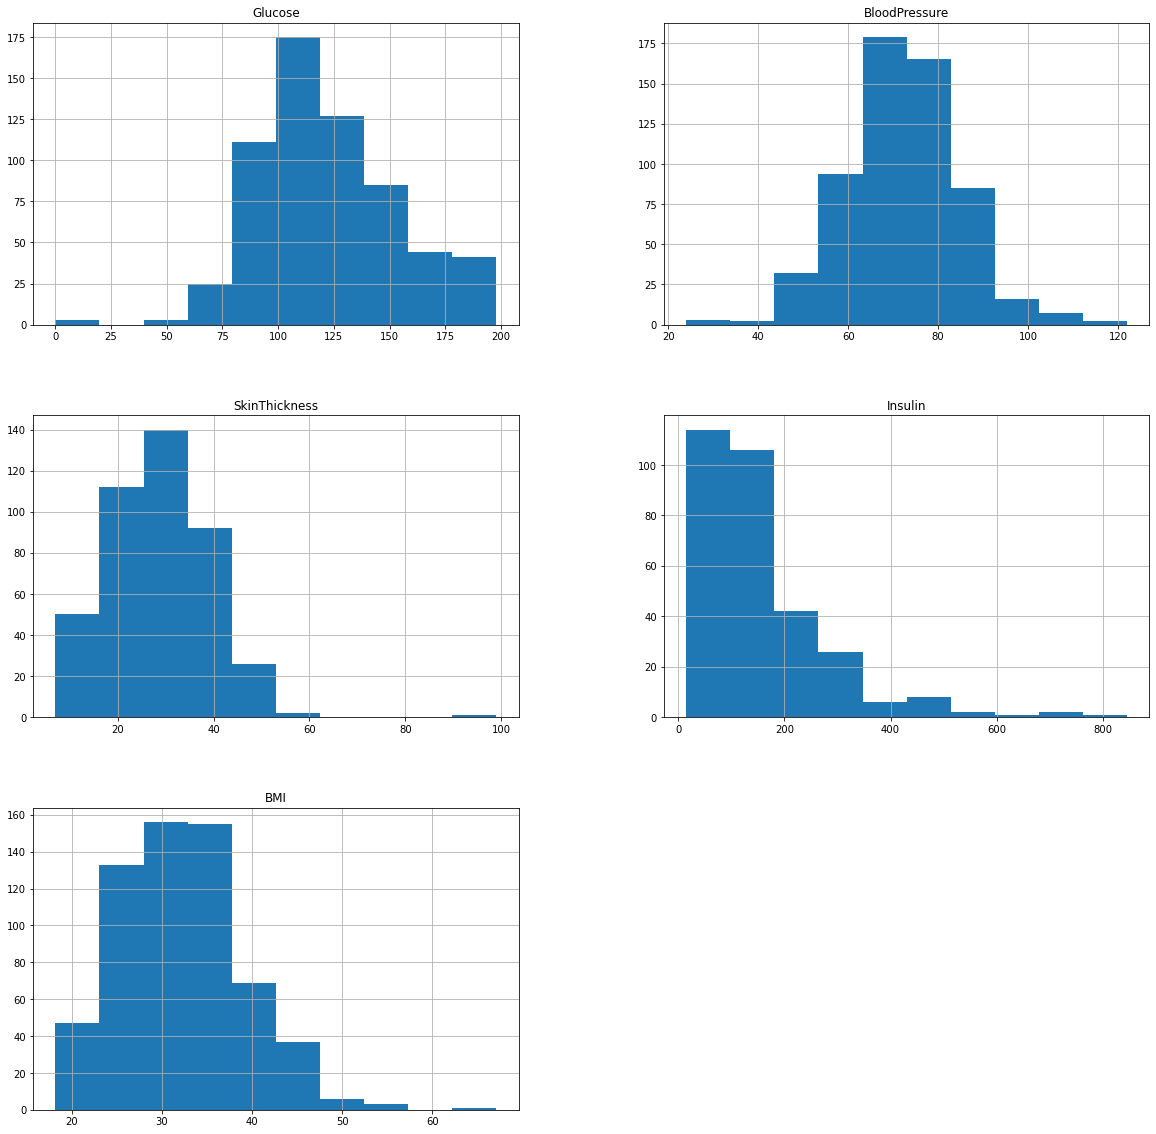

In [12]:
X_train_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].hist(figsize = (20,20));

In [13]:
X_train_copy[['BloodPressure','SkinThickness','Insulin','BMI']].skew(axis = 0, skipna = True)

BloodPressure    0.092568
SkinThickness    0.778479
Insulin          2.184826
BMI              0.580128
dtype: float64

In [14]:
# I will use the mean for the features that follow similiar distributions to the normal distribution.

#Since the skew is less than 1 I will use the mean
avg_BloodPressure =  X_train_copy['BloodPressure'].mean()
avg_SkinThickness =  X_train_copy['SkinThickness'].mean()
avg_BMI =  X_train_copy['BMI'].mean()
#Since the skew is greater than 1 I will use the median
avg_Insulin =  X_train_copy['Insulin'].median()

# Save values to a dict to fill in nan values in the next cell
avg_dict = {"BloodPressure":avg_BloodPressure,
           "SkinThickness":avg_SkinThickness,
           "BMI":avg_BMI,
           "Insulin":avg_Insulin}

In [15]:
# Fill the NaN values using the average found using the train set
X_train_fillna_avg, X_test_fillna_avg = X_train_copy.copy(deep=True), X_test_copy.copy(deep=True)

for key, value in avg_dict.items():
    X_train_fillna_avg[key] = X_train_copy[key].fillna(value)
    X_test_fillna_avg[key] = X_test_copy[key].fillna(value)

In [16]:
X_train_fillna_avg[['BloodPressure','SkinThickness','Insulin','BMI']].skew(axis = 0, skipna = True)

BloodPressure    0.094823
SkinThickness    0.936870
Insulin          3.457563
BMI              0.583447
dtype: float64

In [17]:
X_train_fillna_avg.join(y_train)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
663,9,145,80.0,46.000000,130.0,37.9,0.637,40,1
712,10,129,62.0,36.000000,125.0,41.2,0.441,38,1
161,7,102,74.0,40.000000,105.0,37.2,0.204,45,0
509,8,120,78.0,28.770686,125.0,25.0,0.409,64,0
305,2,120,76.0,37.000000,105.0,39.7,0.215,29,0
...,...,...,...,...,...,...,...,...,...
645,2,157,74.0,35.000000,440.0,39.4,0.134,30,0
715,7,187,50.0,33.000000,392.0,33.9,0.826,34,1
72,13,126,90.0,28.770686,125.0,43.4,0.583,42,1
235,4,171,72.0,28.770686,125.0,43.6,0.479,26,1


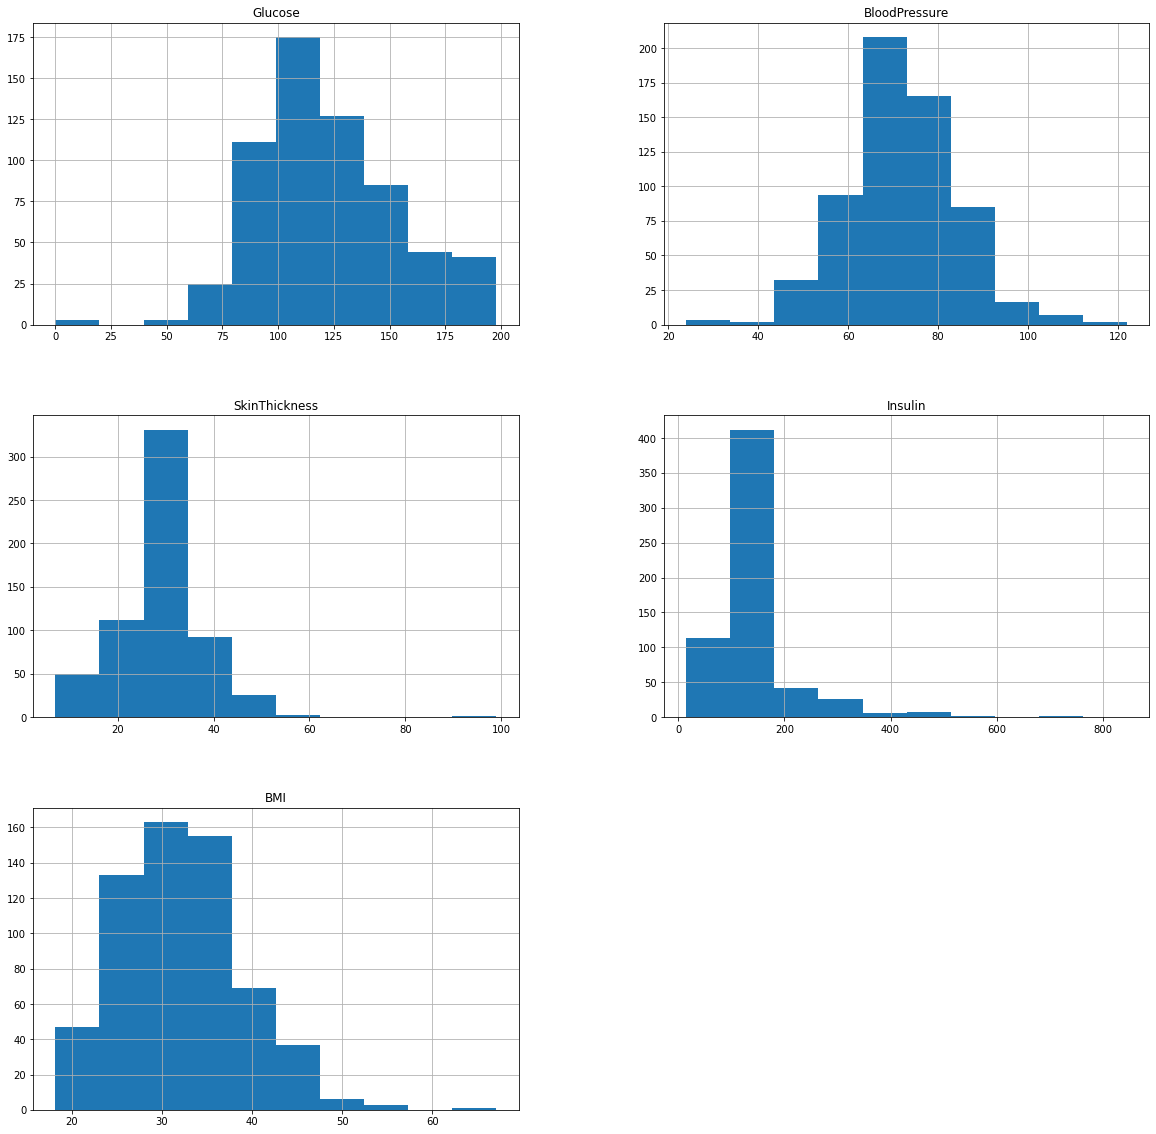

In [18]:
X_train_fillna_avg[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].hist(figsize = (20,20));

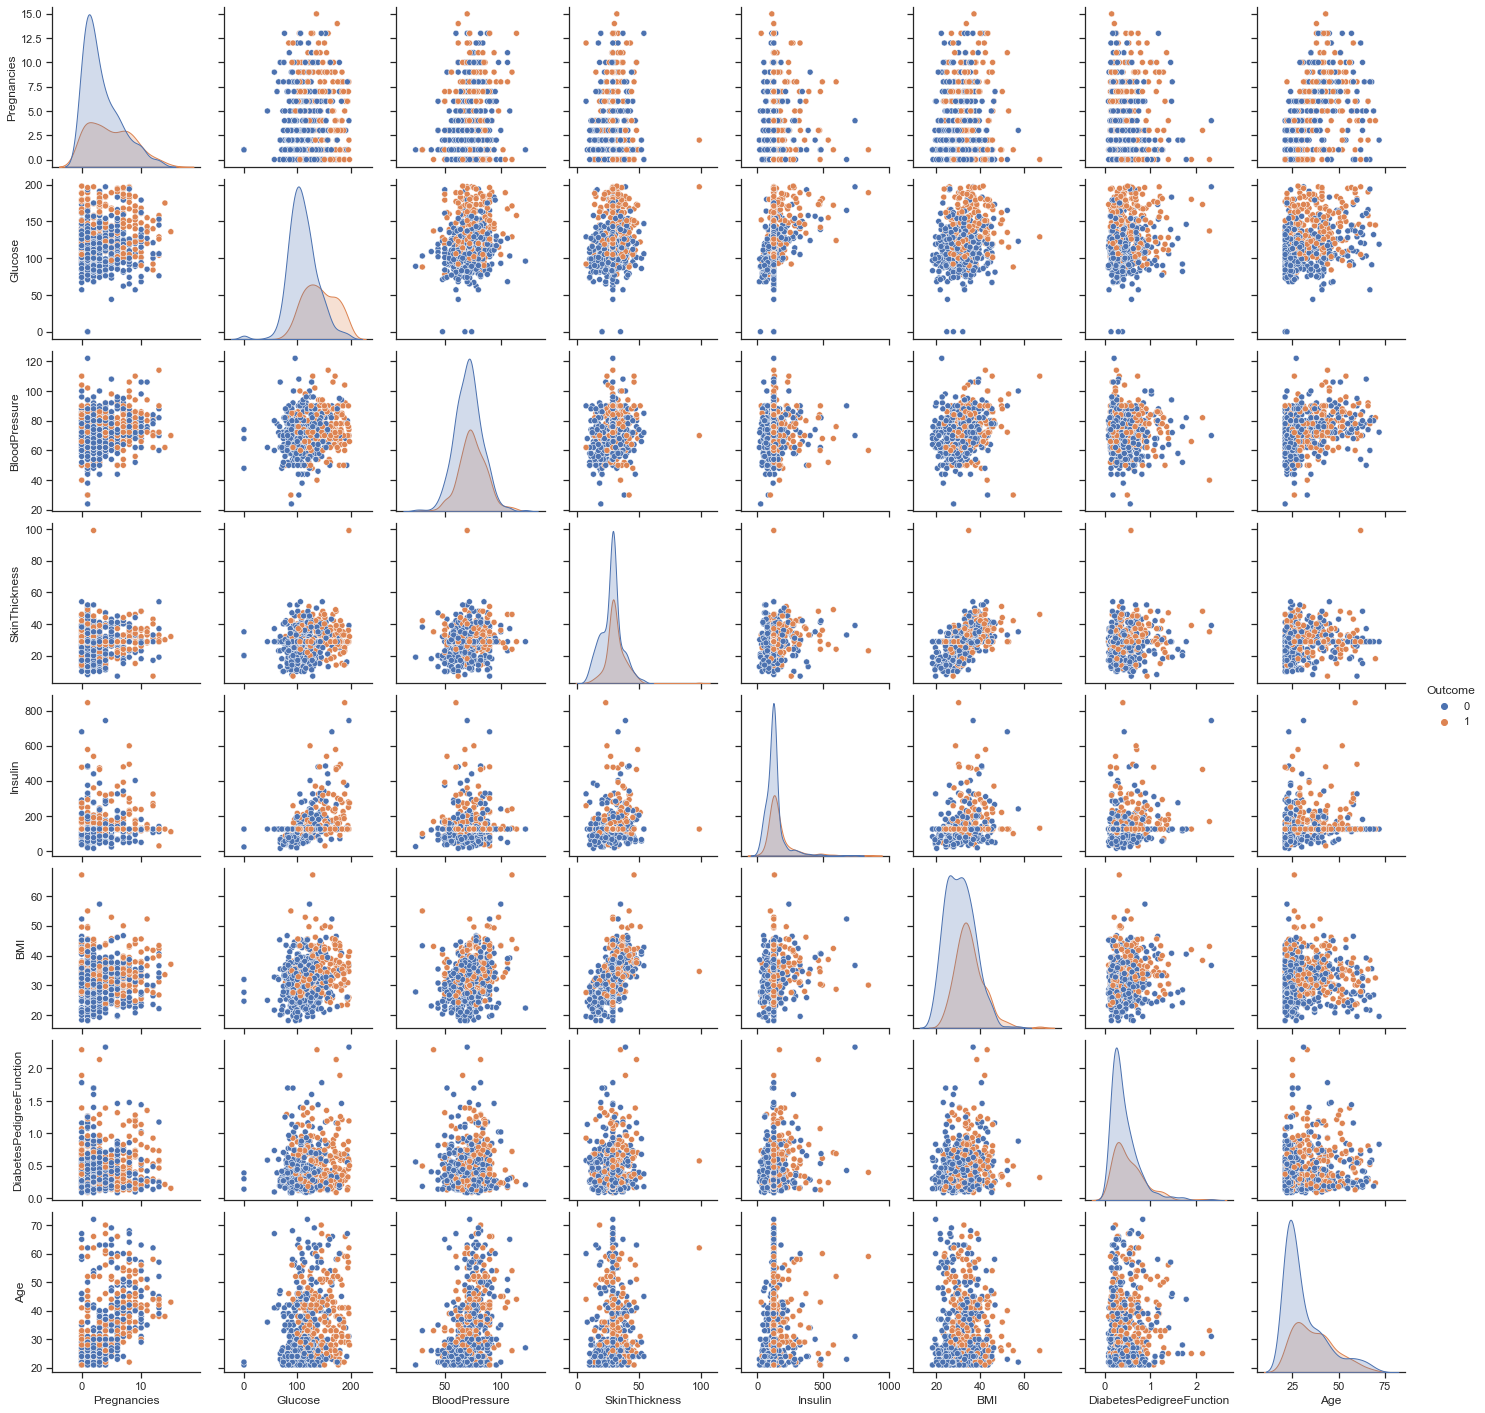

In [19]:
sns.set_theme(style="ticks")
sns.pairplot(X_train_fillna_avg.join(y_train), hue="Outcome");

### Fill in missing values using KNN

In [20]:
"""Fill missing values using KNNImputer function, 
imputer is fitted on the train set and used on both train and test sets."""

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer.fit(X_train_copy)

X_train_fillna_KNN = pd.DataFrame(imputer.transform(X_train_copy), columns=X_train_copy.columns)
X_test_fillna_KNN = pd.DataFrame(imputer.transform(X_test_copy), columns=X_test_copy.columns)

### Scale data using the scale_data function. (MinMaxScaler)

In [21]:
# Scale using MinMaxScaler, I scaled separately to avoid each set effecting eachother.
X_train_fillna_avg_scaled, X_test_fillna_avg_scaled = scale_data(X_train_fillna_avg, X_test_fillna_avg)

X_train_fillna_KNN_scaled, X_test_fillna_KNN_scaled = scale_data(X_train_fillna_KNN, X_test_fillna_KNN)

## Random Forest classifier

In [22]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#### Filled NaN values using averages

In [23]:
best_model = find_best_RFC_model(X_train_fillna_avg, y_train, kf)

In [24]:
y_hat = best_model.predict(X_test_fillna_avg)

print_results(y_hat, y_test)

Confusion matrix:
[[85 19]
 [14 36]]

The accuracy score is: 0.79
The f1 score is: 0.69


#### Filled NaN values using KMeans Imputer

In [25]:
best_model = find_best_RFC_model(X_train_fillna_KNN, y_train, kf)

In [26]:
y_hat = best_model.predict(X_test_fillna_KNN)

print_results(y_hat, y_test)

Confusion matrix:
[[86 22]
 [13 33]]

The accuracy score is: 0.77
The f1 score is: 0.65


## Automated ML method via PyCaret

In [27]:
print(sklearn.__version__)

1.1.2


In [23]:
clf1 = setup(data =X_train_fillna_avg.join(y_train).reset_index(drop=True), target = "Outcome")

# compare models
best = compare_models(sort = "F1")

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:03:11
Status,. . . . . . . . . . . . . . . . . .,Preparing Data for Modeling


ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [ ]:
clf1 = setup(data = X_train_fillna_KNN.join(y_train), target = "Outcome")

# compare models
best = compare_models(sort = 'F1')